# Market Risk Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Question A (Ex2, part of Q1 and of Q2 of TD1)

### a) From the time series of the daily prices of the stock Natixis between January 2015 and December 2016, provided with TD1, estimate a historical VaR on price returns at a one-day horizon for a given probability level (this probability is a parameter which must be changed easily). You must base your VaR on a non-parametric distribution (logistic Kernel, that is $K$ is the derivative of the logistic function $x \mapsto \frac{1}{1 + e^{-x}}$

We import dataset and compute price returns for each of the days

In [2]:
df = pd.read_csv("NatixisStock.csv", sep=';')
print(df.shape)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Price'] = df['Price'].str.replace(',', '.', regex=False).astype(float)
df['Returns']=(df['Price']-df['Price'].shift(1))/df['Price'].shift(1)
df.dropna()

(1023, 2)


,Date,Price,Returns
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836
5,2015-01-09,5.340,-0.020723
...,...,...,...
1018,2018-12-21,4.045,-0.001481
1019,2018-12-24,4.010,-0.008653
1020,2018-12-27,3.938,-0.017955
1021,2018-12-28,4.088,0.038090


In [5]:
#We extract the sample
sample = df[(df['Date'] >= '2015-01-01')&(df['Date']<= '2016-12-31')].copy()

Then compute the non parametric kernel density estimator

__In this exercice we have the logistic function:__
__$$\mathcal{K}(x) =\frac{1}{1+e^{-x}}$$__
__Then taking the derivative we have that the following kernel  : \begin{equation}K(x) = \frac{e^{-x}}{(1 + e^{-x})^2}=\mathcal{K}(x)(1 - \mathcal{K}(x))\end{equation}__

According to : Introduction to Nonparametric Estimation from A.TSYBAKOV

Let $X_1,\dots,X_n$ representing returns be independent identically distributed random variables a basic estimator of the cumulative distribution function is the moment estimator such that :  
$$E[\mathbf{1}_{\{X \leq x\}}] = F(x)$$  
$$=> F_n(x) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}_{\{X_i \leq x\}}$$  

By the strong law of large numbers, we have that :
$$F_n(x) \to F(x), \quad \forall x \in \mathbb{R}$$  
Therefore, $F_n(x)$ is a consistent estimator of $F(x)$. 

How can we estimate the density $f$ ? Recalling the definition of the derivative we have :

$$f(x) = \lim_{h \to 0} \frac{F(x + h) - F(x)}{h}$$

For sufficiently small $h > 0$ we can write an approximation of $f$

$$f(x) \approx \frac{F(x + h) - F(x - h)}{2h}$$ 

Replacing $F$ by the estimate $F_n$, we define  
$$\hat{f}(x) = \frac{F_n(x + h) - F_n(x - h)}{2h}$$  

The function $\hat{f}$ is an estimator of $f$ called the Rosenblatt estimator. We can rewrite it in the form :  
$$\hat{f}(x) = \frac{1}{2nh} \sum_{i=1}^n \mathbf{1}_{\{x - h \leq X_i \leq x + h\}} = \frac{1}{nh} \sum_{i=1}^n K_0\left(\frac{X_i - x}{h}\right)$$  
where $K_0(u) = \frac{1}{2} I(-1 \leq u \leq 1)$. 
A simple generalization of the Rosenblatt estimator is given by  : $$\hat{f}_n(x) = \frac{1}{nh} \sum_{i=1}^n K\left(\frac{X_i - x}{h}\right)$$
And therefore by integration: $$\hat{F}_n(x) = \frac{1}{n} \sum_{i=1}^n \mathcal{K}\left(\frac{X_i - x}{h}\right)$$

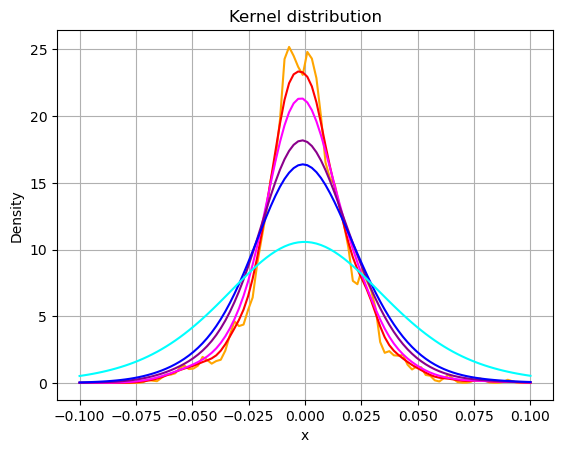

In [6]:
def logistic_function(x):
    return 1 / (1 + np.exp(-x))

def density(x):
    y = logistic_function(x)
    return y * (1 - y)

def kernel_density_estimator(x,tab, h):
    n =len(tab)
    kde = 0
    for i in range(n):
        kde += density((x-tab[i])/h)
    return kde/(n*h)

returns= df['Returns'].dropna().values.astype(float)
time = np.linspace(-0.1, 0.1, 100)
plt.plot(time, kernel_density_estimator(time, returns, h=0.001), label="h=0.001", color="orange")
plt.plot(time, kernel_density_estimator(time, returns, h=0.003), label="h=0.003", color="red")
plt.plot(time, kernel_density_estimator(time, returns, h=0.005), label="h=0.005", color="magenta")
plt.plot(time, kernel_density_estimator(time, returns, h=0.008), label="h=0.008", color="darkmagenta")
plt.plot(time, kernel_density_estimator(time, returns, h=0.01), label="h=0.01", color="blue")
plt.plot(time, kernel_density_estimator(time, returns, h=0.02), label="h=0.02", color="cyan")

plt.title("Kernel distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid()
plt.show()

Using the Scott's rule of thumb to choose an optimal bandwidth of a non-parametric kernel density estimator. The formula is :

$$ h =\left({\frac {4{\hat {\sigma }}^{5}}{3n}}\right)^{\frac {1}{5}}\approx 1.06 \hat{\sigma} \cdot n^{-1/5}$$

In [11]:
# Calculate the bandwidth for the kernel density estimation using the 
returns_sample = sample['Returns'].dropna().values.astype(float)
n = len(returns_sample)
#Using Scott's rule of thumb
h =  np.std(returns_sample) * (n ** (-1/5)) * ((3/4) ** (-1/5))
array = np.linspace(min(returns_sample), max(returns_sample), num=1000)
print("Optimal bandwidth h : ",h)

Optimal bandwidth h :  0.007259254280370997


Now that we have obtained the kernel density estimator $\hat{f}$, we need to integrate it to obtain the cumulative distribution of the kernel density estimator $\hat{F}(x)$.

To do this, we will compute the cumulative sum of an array of probabilies :
$$F(x) = P(X \leq x) = \sum_{i=1}^{n} P(X = x_i) \mathbb{1}_{\{x_i \leq x\}}$$
Finally to ensure that we have a cdf we will normalize this cdf.

In [8]:
def compute_cdf(tab, h, array):
    kde_values = np.array([kernel_density_estimator(x, tab, h) for x in array])
    #We compute the cumulative sum of the kde
    cdf = np.cumsum(kde_values)
    #We normalize the values in order to obtain a cdf
    cdf /= cdf[-1] 
    return np.array(cdf)

According to the course from M.GARCIN : 
Let $X $ be the price return that is a random variable and $F$ be its cumulative distribution function (cdf) :

$$ F^{-1}(p) = \inf \{ x \in \mathbb{R}, F(x) \geq p \}$$

The value at risk is a quantile that we can compute using the inverse cdf such that :
$$ \text{VaR}_\alpha(X) = F_X^{-1}(\alpha)$$

In [9]:
def var_non_parametric(cdf, array, alpha):
    for i in range(len(cdf)):
        if cdf[i] >= alpha:
            return array[i]


#Compute the cdf of the kde
cdf_kde = compute_cdf(returns_sample,h, array)
#Assuming we want a confidence of 95% the probability level for VaR calculation
alpha = 0.05
#Compute the non parametric VaR
var_5_percent= var_non_parametric(cdf_kde,array, alpha)
print("The non parametric value at risk at a level of confidence of 5% is :",var_5_percent)

The non parametric value at risk at a level of confidence of 5% is : -0.0430718741420372


### b)  Which proportion of price returns between January 2017 and December 2018 exceed the VaR threshold defined in the previous question? Do you validate the choice of this non-parametric VaR?

In [10]:
out_sample = df[(df['Date'] >= '2017-01-01')&(df['Date']<= '2018-12-31')].copy()
values =out_sample[out_sample['Returns'].dropna() < var_5_percent]
proportion = len(values)/len(out_sample['Returns'])

print("The proportion of values exceeding the value at risk out of the sample is :",proportion)

The proportion of values exceeding the value at risk out of the sample is : 0.013725490196078431


__This proportion is less than 5%, which allows us to validate it. However it is slightly below 5%, indicating that this Value at Risk might be overly conservative__

## Question B (Ex2, Q4 of TD2)
We want to calculate the VaR (on the arithmetic variation of price, at a one-day horizon) for a call
option on the Natixis stock. You will implement a Monte-Carlo VaR since the call price is a non-linear
function of the underlying price, that we are able to model thanks to historical data. Here is, in detail,
how you must proceed:
- Estimate the parameters of a standard Brownian motion on the Natixis stock between 2015
and 2018, using an exponential weighting of the data.
- Simulate a number N (say N=1000 or else, but justify your choice for this number) of prices of
the stock in a one-day horizon (we are working at the last date of 2018).
- Transform each of these prices of underlying in prices of the corresponding call (say at the
money, with one-month maturity and 0 risk-free rate and dividend).
- Pick the empirical quantile of these N call prices to build the VaR of the call. 

Let's first calculate the mean mu of the return :
\begin{equation}
\mu = \frac{1}{n} \sum_{i=1}^{n} r_i
\end{equation}
and the volatility using this formula :
\begin{equation}
 \text{volatility} = \sqrt{\mathbb{E}[(r - \mu)^2]}
\end{equation}
with r the returns

In [14]:
mean = np.mean(df['Returns'])
df['scare_returns'] = df['Returns']**2
print(f"The mean is : {mean}")

The mean is : -9.696604801149695e-05


Now, we need to calculate the weighted volatility. This approach assigns greater importance to the most recent volatilities. To achieve this, we use the following formula:
\begin{equation}
\sigma_t = \sqrt{(1 - \lambda) \sum_{i=1}^{n} \lambda^{n-i} \cdot \text{returns}_i^2}
\end{equation}


In [15]:
def calcul_volatility(df,lambda_value):
    variance = 0
    for i in range(1, len(df) ): 
        lambda_power = lambda_value ** (len(df) - i - 1)
        rendement_carres = df['scare_returns'][i]
        variance = variance + (1 - lambda_value) * rendement_carres * lambda_power
       
    volatilite = variance ** 0.5
    return volatilite

volatilite = calcul_volatility(df,0.94)
print("Estimated volatility :", volatilite)

Estimated volatility : 0.02424224156705615


Now, we need to identify the most recent price to serve as the starting point for simulating future prices.

S0 = df.tail(1)['Price'].values[0]
print(f"Initial price: {S0}")

Now we choose 𝑁=1000 simulations strikes a balance between accuracy and computational efficiency. It ensures statistical reliability, leveraging the law of large numbers to approximate the true distribution of simulated prices. This value is commonly used in financial modeling to achieve consistent results without excessive computational costs. Also we choose T=21 which represent approxiamtively the number of trading day in a month.

In this step, we simulate 1000 possible prices of the Natixis stock for a one-day horizon using the formula for the geometric Brownian motion:

\begin{equation}
S_T = S_0 \cdot e^{\left( \mu - \frac{\sigma^2}{2} \right) \Delta t + \sigma \sqrt{\Delta t} \cdot Z}
\end{equation}
with Δt = 1 because it is a one day horizon and : 
\begin{equation}
Z \sim \mathcal{N}(0, 1)
\end{equation}

In [ ]:
N = 1000  
T = 1 

np.random.seed(0)
simulated_prices = np.zeros(N)
#here we can neglect delta t because it is equal to 1
for i in range(N):
    z = np.random.normal()
    simulated_price = S0 * np.exp((mean - 0.5 * volatilite ** 2)  + volatilite * z)
    simulated_prices[i] = 

simulated_data = pd.DataFrame(simulated_prices, columns=['simulated_prices'])
simulated_data['d1'] = 0
simulated_data['d2'] = 0
simulated_data['call_price']=0
simulated_data.head()

In this step, we simulate 1000 possible prices of the Natixis stock for a one-day horizon using the formula for the geometric Brownian motion:

\begin{equation}
S_T = S_0 \cdot e^{\left( \mu - \frac{\sigma^2}{2} \right) \Delta t + \sigma \sqrt{\Delta t} \cdot Z}
\end{equation}
with Δt = 1 because it is a one day horizon and : 
\begin{equation}
Z \sim \mathcal{N}(0, 1)
\end{equation}

Here we calculate d1 and d2 by using the following formulas : 

\begin{equation}
d_1 = \frac{\ln \left( \frac{K}{S_0} \right) + \left( r + \frac{\sigma^2}{2} \right) T}{\sigma \sqrt{T}}
\end{equation}
and 
\begin{equation}
d_2 = d_1 - \sigma \sqrt{T}
\end{equation}
Then we can calculate the price of a call corresponding with the formula : 

\begin{equation}
C(S_{0},K,r,T,\sigma ) = S_{0} \mathcal{N}(d_{1}) - K e^{-rT} \mathcal{N}(d_{2})
\end{equation}
where : 



In [ ]:
from scipy.stats import norm

def BS(df, K, T, r, volatility):
   
    for index, row in df.iterrows():

        S_0 = row['simulated_prices']  # Prix simulé
        # Calcul de d1 et d2 selon la formule de Black-Scholes
        d1 = (np.log(S_0 / K) + (r + 0.5 * volatility**2) * T) / (volatility * np.sqrt(T))
        d2 = d1 - volatility * np.sqrt(T)
        c = S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        # Mise à jour des colonnes 'd1' et 'd2'
        simulated_data.at[index, 'd1'] = d1
        simulated_data.at[index, 'd2'] = d2
        simulated_data.at[index, 'call_price'] = c

BS(simulated_data, 4, 21, 0, volatilite)
simulated_data.tail()

In [ ]:
mport numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

# Plot the histogram of call prices
plt.hist(simulated_data['call_price'], bins=30, density=True, alpha=0.6, color='b', label='Call Prices')

# Fit a normal distribution to the data
mu, std = norm.fit(simulated_data['call_price'])

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')

# Add labels and title
plt.xlabel('Call Price')
plt.ylabel('Density')
plt.title('Distribution of Call Prices with Fitted Normal Distribution')
plt.legend()
# Show the plot
plt.show()

Now, we define a method called Value_at_Risk that sorts the different Call_price values in ascending order and then identifies a quantile passed as a parameter. This allows us to calculate the empirical Value at Risk using the Monte Carlo method (by utilizing all the prices we have simulated).


## Question C (Ex2, Q1 and Q3 of TD3)
With the dataset provided for TD1 on Natixis prices, first calculate daily returns. You will then analyse
these returns using a specific method in the field of the EVT.

### a) Estimate the GEV parameters for the two tails of the distribution of returns, using the estimator of Pickands. What can you conclude about the nature of the extreme gains and losses? 

The first step is create two new datasets: one containing only positive returns and the other containing only negative returns. This separation enables a focused and independent analysis of both tails of the distribution.

In [18]:
df_positifs = df[df['Returns'] > 0].copy()
df_negatifs = df[df['Returns'] < 0].copy()

Now, we create again two new datasets. For df_positif, we add a column absolut_returns, where the returns are sorted in ascending order (a necessary step for calculating the Pickands estimator). For df_negatif, we first convert all returns to their absolute values, then sort them in ascending order as well.

In [19]:
df_positifs_sorted = df_positifs.sort_values(by='Returns', ascending=True).reset_index(drop=True)
df_negatifs_sorted = df_negatifs.assign(Rendement_Absolu=np.abs(df_negatifs['Returns'])).sort_values(by='Rendement_Absolu', ascending=True).reset_index(drop=True)

We now create our method  k to initialize the function  k(n) with the following criteria:

\begin{equation}
\lim_{n \to \infty} k(n) = \infty
\end{equation}

and

\begin{equation}
\lim_{n \to \infty} \frac{k(n)}{n} = 0
\end{equation}

Here we choose :

\begin{equation}
\ k(n) = \log(n) \
 \end{equation}

The logarithme, is commonly used when calculating the Pickands estimator.

In [22]:
def k(n):
    return int(np.log(n))

print("The value of k is :", k(len(df)))

The value of k is : 6


According to the course from M.GARCIN

Let $(X_n)$ be a sequence of independent (this is a unrealistic asumption that we will try to avoid after) identically distributed random variables with distribution function F belonging to the max-domain of attraction of a GEV law with parameter $\xi \in \mathbb{R}$.
Now we define our methode Pickand_ Estimator that will implement this formula : 

\begin{equation}
\xi_{P_{k(n),n}} = \frac{1}{\log(2)} \log \left( \frac{X_{n-k(n)+1:n} - X_{n-2k(n)+1:n}}{X_{n-2k(n)+1:n} - X_{n-4k(n)+1:n}} \right)
\end{equation}
converges in probability to $\xi$. 

In [23]:
def Pickand_Estimator(df):
    n=len(df)
    pickand = (1 / np.log(2)) * np.log((df['Returns'].iloc[n - int(k(n))] - df['Returns'].iloc[n - 2 * int(k(n)) ]) / 
     (df['Returns'].iloc[n - 2 * int(k(n))] - df['Returns'].iloc[n - 4 * int(k(n)) ]))
    return pickand

print("Pickand estimator for our positive returns :", Pickand_Estimator(df_positifs_sorted))

print("Pickand estimator for our negative returns :", Pickand_Estimator(df_negatifs_sorted))

Pickand estimator for our positive returns : 0.5772338569463286
Pickand estimator for our negative returns : -0.508971577934174


**We can conclude that:**

The GEV parameters estimated using the Pickands estimator indicate the following :

- __For the positive tail :__ The Pickands estimator for positive returns is $\xi \approx$ 0.577, which corresponds to a heavy tail (Fréchet type). This suggests that extreme gains are rare but can be very significant.

- __For the negative tail :__ The Pickands estimator for negative returns is $\xi \approx$ -0.509 , which corresponds to a bounded tail (Weibull type). This indicates that extreme losses are limited by a threshold and their probability decays rapidly.

### b) Determine the extremal index using the block or run de-clustering. 

Here, we will implement the run de-clustering method, which involves analyzing the occurrences of extreme values in a time series by grouping successive observations that exceed a certain threshold 
𝑢. This method allows us to calculate the extremal index 
𝜃, which quantifies the degree of temporal dependence among extreme values.

According to the course from M. GARCIN

To calculate the extremal index 𝜃 , we will use the following formula:

\begin{equation}
\hat{\theta}_{n}(u; r) = \frac{\sum_{i=1}^{n-r} \mathbf{1}(X_i > u, M_{i,i+r} \leq u)}{\sum_{i=1}^{n-r} \mathbf{1}(X_i > u)}
\end{equation}

In this formula:

- The **numerator** is a sum of indicator functions that take the value 1  if, for an observation X_i , the value exceeds the threshold  𝑢 **and** no other value exceeds the threshold  𝑢 in the time window of size r  (the run). This corresponds to the number of distinct extreme clusters.
- The **denominator** is also a sum of indicator functions, which take the value  1  whenever an observation exceeds the threshold 𝑢. This corresponds to the total number of threshold exceedances in the series.

The extremal index 𝜃 therefore represents the ratio between the number of extreme clusters and the total number of extreme observations.

Two approaches are possible here: either we calculate one index for positive returns and another for negative returns, or we use the absolute values of the returns to calculate a single index. In this case, we will follow the first approach, which is the one implemented during the tutorial sessions.

In [45]:
def extremal_index_run_declustering(returns, u, r):
    n = len(returns)
    numerator = 0
    denominator = 0
    if(u>0) :
        #We compute the sum with a loop
        for i in range(n - r):
            #We check if the current value is above the threshold to satisfy the indicatrice
            if returns[i] > u:
                denominator += 1
    
                #We compute the maximum within the run window [i, i+r]
                if np.max(returns[i + 1:i + r + 1]) <= u:
                    numerator += 1
    else :
        #We compute the sum with a looph
        for i in range(n - r):
            # We check if the current value is below the threshold to satisfy the indicatrice
            if returns[i] < u:
                denominator += 1
    
                #We compute the minimum within the run window [i, i+r]
                if np.min(returns[i + 1:i + r + 1]) >= u:
                    numerator += 1

    theta = numerator / denominator
    return theta

To use this method, it is important first to add an abs_returns column in order to account for both positive and negative returns. Next, we define our threshold $u$, which in this case is 0.05, indicating a return threshold of 5% (or -5%), and our parameter $r$, which is set to 5 and 22 days, roughly corresponding to a trading week.

In [46]:
returns = df['Returns'].dropna().values.astype(float)
print("Theta value for an independence between weeks :", extremal_index_run_declustering(returns, 0.05,5))
print("Theta value for an independence between months :",extremal_index_run_declustering(returns, 0.05, 22))

Theta value for an independence between weeks : 0.8333333333333334
Theta value for an independence between months : 0.5


The result of 
$\theta \approx 0.8333$ is more close to 1 meaning that with the threshold $u=0.05$ (which corresponds to a $5$% return, whether positive or negative), approximately $83.33$% of the returns exceeding this threshold occur in isolation, meaning there are no other returns exceeding this threshold within the following 5-day period.
This suggests that positive extreme events tend to be more clustered in weeks rather than in months.

In [47]:
print("Theta value for an independence between weeks :", extremal_index_run_declustering(returns, -0.05,5))
print("Theta value for an independence between months :",extremal_index_run_declustering(returns,-0.05, 22))

Theta value for an independence between weeks : 0.8666666666666667
Theta value for an independence between months : 0.46153846153846156


We obtain similar results of $\theta$ for the threshold $u=-0.05$ this suggests that negative extreme events tend to be more clustered in weeks rather than in months.

## Question D (Ex2, Q3 and Q4 of TD4)
With the dataset provided for TD4:

First we will have to import our dataset, convert column to usable types of data and we rename the columns 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("Dataset TD4.csv", sep=';')

#We replace commas with dots in object columns and convert to float
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float, errors='ignore')

df.rename(columns={'transaction date (1=1day=24 hours)': 'Date',
                   'bid-ask spread': 'Spread',
                   'volume of the transaction (if known)': 'Volume',
                   'Sign of the transaction': 'Sign',
                   'Price (before transaction)': 'Price'}, inplace=True)

### a) Estimate all the parameters of the model of Almgren and Chriss. Is this model well specified?

Then according to the course from M.GARCIN :
- The function that models the permanent impact which is linear is : $$g(v) = \gamma v$$
  With $v$ the volume of the transaction

- The function that models the transitional impact is :
 $$h\left(\frac{n_k}{\tau}\right) = \xi \, \mathrm{sgn}(n_k) + \eta \frac{n_k}{\tau}$$
- __Parameter $\gamma$ and $\eta$ have to be estimated__

- Price dynamics according to an arithmetic random walk: 
$$
S_k = S_{k-1} + \sigma\sqrt{\tau}\epsilon_k - \tau g\left(\frac{n_k}{\tau}\right)
$$

__We can estimate $\gamma$ using a linear regression with the formula :__

$$
S_k - S_{k-1} = \sigma\sqrt{\tau}\epsilon_k - \gamma n_k 
$$

In [16]:
df_copy = df.copy()
#Create price_difference as S_k - S_{k-1}
df['Price_Difference']=df['Price'].shift(-1) - df['Price']
#We drop the nan values from our dataset to compute the linear regression
df = df.dropna(subset=['Price_Difference','Volume'])

#We drop outliers to have a more accurate linear regression
def rem_outlier(df, col):
    quantile1= df[col].quantile(0.25)
    quantile3 = df[col].quantile(0.75)
    I = quantile3 - quantile1
    lower_bound = quantile1-1.5 * I
    upper_bound = quantile3+1.5 * I

    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

#We do it for the two main columns
df = rem_outlier(df, 'Price_Difference')
df = rem_outlier(df, 'Volume')

price_difference = df['Price_Difference'].values.astype(float)
volume_signed = (df['Volume'].values.astype(int)) * (df['Sign'].values.astype(int))

Our statistics course provide us that for the linear regression the goal is to minimize the sum of squared residuals and the model can be written as :
$$
y = X\beta + \epsilon
$$

Here we want to estimate beta (containing our gamma) therefore we can compute the estimator of beta

$$
\hat{\beta} = (X^T X)^{-1} X^T y
$$
To see if we made some good predictions we will use the Mean Squared Error (MSE) and the R2 Score : 

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$
$$
R^2 = 1 - \frac{\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\frac{1}{n}\sum_{i=1}^n (y_i - \bar{y})^2}$$

In [17]:
def linear_regression(X, y):
    X = np.c_[np.ones((X.shape[0], 1)), X]  #Add a column of "1" to X
    beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) #Compute beta hat
    y_pred = X.dot(beta_hat) #Compute y_pred
    
    return beta_hat, y_pred

def mse(y_true,y_pred):
    return np.mean((y_true - y_pred)*(y_true - y_pred))

def r2(y_true,y_pred):
    sum_tot = np.sum((y_true - np.mean(y_true))*(y_true - np.mean(y_true)))
    sum_residual = np.sum((y_true - y_pred)*(y_true - y_pred))
    
    return 1 - (sum_residual / sum_tot)

In [18]:
X = volume_signed.reshape(-1,1)
y = price_difference

beta_hat, y_pred_gamma = linear_regression(X, y)
gamma_estimated = beta_hat[1]

print(f'Estimated gamma : {gamma_estimated}')
print(f'The Mean Squared Error is : {mse(price_difference,y_pred_gamma)}')
print(f'The R2 score is : {r2(price_difference,y_pred_gamma)}')

Estimated gamma : 0.0005702702332606549
The Mean Squared Error is : 0.00029036018460583776
The R2 score is : 0.9443789746702551


According to the course and Optimal Execution of Portfolio Transactions from ALMGREN and CHRISS:
 
 $$h\left(\frac{n_k}{\tau}\right) = \xi \, \mathrm{sgn}(n_k) + \eta \frac{n_k}{\tau}$$
This model for \( h \) is often called the quadratic cost model, because the associated cost is given by :

$$
n_k h\left(\frac{n_k}{\tau}\right) = \xi |n_k| + \eta\frac{n_k^2}{\tau}
$$
- The assumption is that the observed price is different from the underlying dynamics because of a transitory impact (the trader exhausts the order book between $t_{k-1}$ and $t_k$, but it is instantly replenished in $t_k$): 
$$
\bar{S}_k = S_{k-1} - h\left(\frac{n_k}{\tau}\right)
$$

__We can also estimate $\eta$ using a linear regression with:__
$$S_k - S_{k-1} = \xi |n_k| + \eta \frac{n_k^2}{\tau}$$

In [19]:
volume_signed_squared = (df['Volume'].values.astype(int))*(df['Volume'].values.astype(int)) *(df['Sign'].values.astype(int))

X = np.column_stack((volume_signed, volume_signed_squared))
y = -price_difference
beta_hat, y_pred_eta  = linear_regression(X, y)
eta_estimated = beta_hat[2]/24.0

print(f"Estimated Eta: {eta_estimated}")
print(f'The Mean Squared Error is : {mse(-price_difference,y_pred_eta)}')
print(f'The R2 score is : {r2(-price_difference,y_pred_eta)}')

Estimated Eta: 6.479775443366111e-08
The Mean Squared Error is : 0.00015852718136557
The R2 score is : 0.9696327360372874


Finally we will compute the following parameters for the Almgren and Chriss Model with the original data and not with the data where we drop lots of columns :
- Parameter $\xi$ wich is half the bid-ask spread
- Parameter $\sigma$ wich is the standard deviation of the returns
- Parameter $\tau$ given in the question wich is the time step (here 1/24)

In [22]:
df_copy['Returns'] = (df_copy['Price'] - df_copy['Price'].shift(1)) / df_copy['Price'].shift(1)
returns = df_copy['Returns'].values.astype(float)[1:]

#By definition xi is the half the mean of the bid ask spread
mean_spread = np.mean(df_copy['Spread'].values.astype(float)) 
xi = mean_spread/2
#To annualize volatility
sigma =np.std(returns)*np.sqrt(24)*np.sqrt(252)
tau = 1/24.0
print(f'We annualize volatility : {sigma}')
print(f'Mean half spread : {xi}')

We annualize volatility : 0.05739752288974415
Mean half spread : 0.05026138861138861


__Reaching good MSE and R2 score for our two linear regression we can say that the model is well specified and that we correctly predicted the parameters__

### b) In the framework of Almgren and Chriss, what is your liquidation strategy (we recall that you can only make transactions once every hour).
According to our course from M.GARCIN
- Quantity $X$ to be liquidated by instalments $n_1$, $n_2$, ..., with 
  $$
  x_k = X - \sum_{j=1}^{k} n_j
  $$

- Discrete time trading, time step $\tau$ here $1/24$ and $k \in \{1, \dots, 24\}$.
  
By Euler Lagrange
$$x_k = X \frac{\sinh(K(T-(k-\frac{1}{2}\tau))}{\sinh(KT)}$$
$$K = \lim_{\tau \to 0} \sqrt{\frac{\lambda\sigma^2}{\eta}} + O(\tau)$$

We will try various strategies depending on the risk aversion of the trader wich is $\lambda$ and we remind if  $\lambda$ is higher the trader is willing to sell quickly to reduce exposure to volatility risk and it can even be negative if the trader
likes risk.


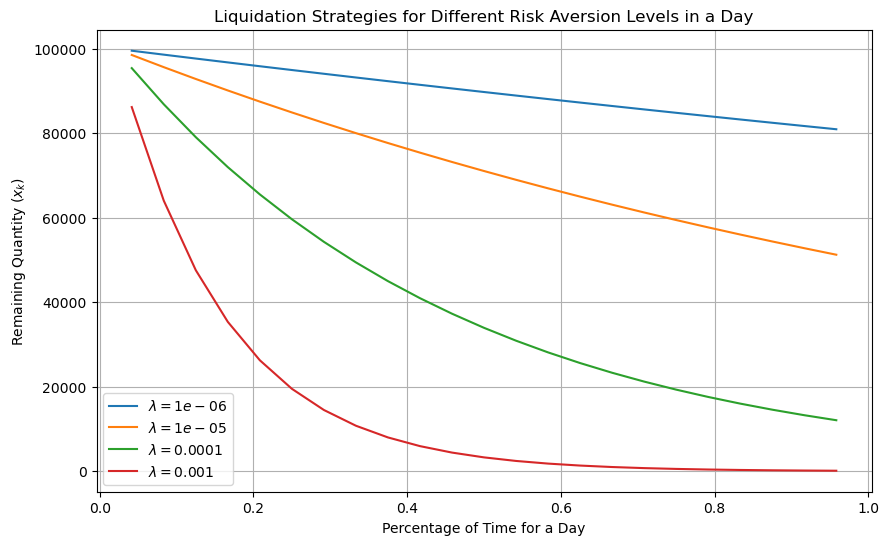

 We have to make these transactions in order and every hour to perform our optimal strategy : [95411.07190073364, 86855.3000506008, 79066.7476697936, 71976.61608948196, 65522.276005692656, 59646.7142554863, 54298.03020222477, 49428.97728135212, 44996.5456570157, 40961.58230301339, 37288.44515212156, 33944.688258794864, 30900.775194194655, 28129.818141864114, 25607.340389408593, 23311.060118200498, 21220.693581248084, 19317.775930646214, 17585.498111919333, 16008.558384493772, 14573.027156736896, 13266.223941607299, 12076.605346029091]


In [23]:
X = 100000
T = 24  #Total time period in a day

#Time array
times = [(1 / 24) * i for i in range(1, T)]
risk_aversions = [10**(-6),10**(-5),10**(-4),10**(-3)]

#Function to calculate optimal liquidation strategy
def x_k(risk_aversion):
    kappa = np.sqrt(risk_aversion * (sigma * sigma) / eta_estimated)
    optimal_liquidation = [X * np.sinh(kappa * (T - t + tau / 2)) / np.sinh(kappa * T) for t in times]
    return optimal_liquidation

#We plot the different strategies
plt.figure(figsize=(10, 6))

for risk_aversion in risk_aversions:
    optimal_liquidation = x_k(risk_aversion)
    plt.plot(times, optimal_liquidation, label=f"$\\lambda={risk_aversion}$")

plt.title("Liquidation Strategies for Different Risk Aversion Levels in a Day")
plt.xlabel("Percentage of Time for a Day")
plt.ylabel("Remaining Quantity ($x_k$)")
plt.legend()
plt.grid()
plt.show()

#Assuming we want the strategies with the green curve, we will have to make these transactions in order and every hour
optimal_liquidation = x_k(1 * 10**(-4))
print(f' We have to make these transactions in order and every hour to perform our optimal strategy : {optimal_liquidation}')

## Question E (Q2 and Q3 of TD5)


In [2]:
df = pd.read_csv("Dataset TD5.csv", delimiter=';', skiprows=1)
print(df.shape)
print(df.dtypes)

(12929, 11)
Date           object
HIGH           object
LOW            object
Unnamed: 3    float64
Date.1         object
HIGH.1         object
LOW.1          object
Unnamed: 7    float64
Date.2         object
HIGH.2         object
LOW.2          object
dtype: object


In [3]:
df.columns = ['Date_GBPEUR', 'High_GBPEUR', 'Low_GBPEUR', 'NaN1', 'Date_SEKEUR', 'High_SEKEUR', 'Low_SEKEUR', 'NaN2', 'Date_CADEUR', 'High_CADEUR', 'Low_CADEUR']

df_cleaned = df.drop(columns=['NaN1', 'NaN2'])

df_cleaned['Date_GBPEUR'] = pd.to_datetime(df_cleaned['Date_GBPEUR'], format='%d/%m/%Y %H:%M', errors='coerce')
df_cleaned['Date_SEKEUR'] = pd.to_datetime(df_cleaned['Date_SEKEUR'], format='%d/%m/%Y %H:%M', errors='coerce')
df_cleaned['Date_CADEUR'] = pd.to_datetime(df_cleaned['Date_CADEUR'], format='%d/%m/%Y %H:%M', errors='coerce')

for col in df_cleaned.select_dtypes(include=['object']).columns:
    df_cleaned[col] = df_cleaned[col].str.replace(',', '.', regex=False).astype(float, errors='ignore')

df = df_cleaned.copy()
print(df.head(3))

          Date_GBPEUR  High_GBPEUR  Low_GBPEUR         Date_SEKEUR  \
0 2016-03-07 09:00:00       1.2932      1.2917 2016-03-07 09:00:00   
1 2016-03-07 09:15:00       1.2940      1.2930 2016-03-07 09:15:00   
2 2016-03-07 09:30:00       1.2943      1.2922 2016-03-07 09:30:00   

   High_SEKEUR  Low_SEKEUR         Date_CADEUR  High_CADEUR  Low_CADEUR  
0      0.10725     0.10720 2016-03-07 09:00:00       0.6842      0.6829  
1      0.10728     0.10717 2016-03-07 09:15:00       0.6849      0.6841  
2      0.10726     0.10719 2016-03-07 09:30:00       0.6844      0.6837  


We now calculate, for each currency, the average between the highest price and the lowest price for each row. Then with the price we compute the returns

In [4]:
df["PRICE_GBPEUR"]=(df["High_GBPEUR"]+df["Low_GBPEUR"])/2
df["PRICE_SEKEUR"]=(df["High_SEKEUR"]+df["Low_SEKEUR"])/2
df["PRICE_CADEUR"]=(df["High_CADEUR"]+df["Low_CADEUR"])/2

df['RET_GBPEUR']=(df['PRICE_GBPEUR']-df['PRICE_GBPEUR'].shift(1))/df['PRICE_GBPEUR'].shift(1)
df['RET_SEKEUR']=(df['PRICE_SEKEUR']-df['PRICE_SEKEUR'].shift(1))/df['PRICE_SEKEUR'].shift(1)
df['RET_CADEUR']=(df['PRICE_CADEUR']-df['PRICE_CADEUR'].shift(1))/df['PRICE_CADEUR'].shift(1)
df.head(3)
df.tail(3)

,Date_GBPEUR,High_GBPEUR,Low_GBPEUR,Date_SEKEUR,High_SEKEUR,Low_SEKEUR,Date_CADEUR,High_CADEUR,Low_CADEUR,PRICE_GBPEUR,PRICE_SEKEUR,PRICE_CADEUR,RET_GBPEUR,RET_SEKEUR,RET_CADEUR
12926,2016-09-07 17:30:00,1.1880,1.1874,2016-09-07 17:30:00,0.10538,0.10536,2016-09-07 17:30:00,0.6902,0.6898,1.18770,0.105370,0.69000,-0.000126,0.000142,0.000217
12927,2016-09-07 17:45:00,1.1874,1.1866,2016-09-07 17:45:00,0.10537,0.10536,2016-09-07 17:45:00,0.6902,0.6901,1.18700,0.105365,0.69015,-0.000589,-0.000047,0.000217
12928,2016-09-07 18:00:00,1.1870,1.1869,2016-09-07 18:00:00,0.10537,0.10537,2016-09-07 18:00:00,0.6901,0.6901,1.18695,0.105370,0.69010,-0.000042,0.000047,-0.000072


### a) With Haar wavelets and the dataset provided with TD5, determine the multiresolution correlation between all the pairs of FX rates, using GBPEUR, SEKEUR, and CADEUR (work with the average between the highest and the lowest price and transform this average price in returns on the smallest time step). Do you observe an Epps effect and how could you explain this?

The Haar father wavelet is defined as a piecewise constant function as it follows : $$ \phi(t) = \mathbf{1}_{[0,1[} $$

The scaled and translated version of the father wavelet is : $$
\phi_{j,k}(t) = \phi(2^j t - k)
$$

In [5]:
def phi(t):
    if(0<=t and t<1) :
        return 1
    else :
        return 0

def phi_j_k(t, j, k):
    return phi((2**j)*t-k)

In this case, we are can compute the scaling coefficient, which is defined by an empirical integral on a discrete grid and represent the projection of the signal onto the scaling function $\phi_{j,k}$:

$$
c_{\text{empirical}}^{j,k} = \sum_{n=1}^{N} z(n) \phi_{j,k}(n)
$$

In [7]:
def scaling_coefficient(z, j, k):
    return sum([z[i]*phi_j_k(i,j,k) for i in range(len(z))])

The covariance $Cov(j)$ is given by:

$$
\text{Cov}(j) = \frac{1}{T} \sum_{k=1}^{T} c_1(j,k) - \frac{1}{T} \sum_{l=1}^{T} c_1(j,l) \left( c_2(j,k) - \frac{1}{T} \sum_{l=1}^{T} c_2(j,l) \right).
$$

In [14]:
def wavelet_multiresolution_correlation(return_a, return_b, gamma):
    #Storing correlations in an multiresolution correlation
    multiresolution_correlation = {}
    T = len(return_a) - 1  # Length for the returns
    j=0
    while (j <= gamma):  # For each scale j from 0 to gamma
        #We compute the mean of the scaling coefficients for each series at j
        mean_return_a = sum([scaling_coefficient(return_a, j, k) for k in range(2, T+2)]) / T
        mean_return_b = sum([scaling_coefficient(return_b, j, k) for k in range(2, T+2)]) / T

        #We compute the standard deviations for each returns at j
        std_return_a = np.sqrt(sum([(scaling_coefficient(return_a, j, k) - mean_return_a)**2 for k in range(2,T+2)]) / (T))
        std_return_b = np.sqrt(sum([(scaling_coefficient(return_b, j, k) - mean_return_b)**2 for k in range(2,T+2)]) / (T))

        #We compute the covariance at j
        covariance_j = sum([(scaling_coefficient(return_a,j,k)-mean_return_a)*(scaling_coefficient(return_b,j,k)-mean_return_b)
                     for k in range(2,T+2)]) /T
        
        #We compute the multiresolution correlation at j
        correlation_j = covariance_j/(std_return_a*std_return_b)

        #We store the correlation or covariance by scale
        multiresolution_correlation[j] = correlation_j

        print(f"Mean for the return_a at scale {j}: {mean_return_a}")
        print(f"Mean for the return_b at scale {j}: {mean_return_b}")
        print(f"Standard deviation for the return_a at scale {j}: {std_return_a}")
        print(f"Standard deviation for the return_b at scale {j}: {std_return_b}")
        print(f"Covariance at scale {j}: {covariance_j}")
        print(f"Correlation at scale {j}: {correlation_j}")
        j += 1

    return multiresolution_correlation
    
wavelet_multiresolution_correlation(df["RET_GBPEUR"].dropna().values.astype(float), df["RET_SEKEUR"].dropna().values.astype(float),2)

Mean for the return_a at scale 0: -6.440651497492575e-06
Mean for the return_b at scale 0: -1.2964902556189675e-06
Standard deviation for the return_a at scale 0: 0.0006232292103278637
Standard deviation for the return_b at scale 0: 0.00032713099343330146
Covariance at scale 0: 3.902894073319841e-08
Correlation at scale 0: 0.1914332055673699
Mean for the return_a at scale 1: -5.978382538529345e-07
Mean for the return_b at scale 1: 8.697570536314387e-07
Standard deviation for the return_a at scale 1: 0.0003186213309968316
Standard deviation for the return_b at scale 1: 0.00021492807158945824
Covariance at scale 1: 1.1744603003541385e-08
Correlation at scale 1: 0.17150245909769077
Mean for the return_a at scale 2: -1.4836014252329667e-06
Mean for the return_b at scale 2: 1.5454575877296133e-06
Standard deviation for the return_a at scale 2: 0.0002286897258438785
Standard deviation for the return_b at scale 2: 0.00016261897969216597
Covariance at scale 2: 8.10647883072942e-09
Correlation 

{0: 0.1914332055673699, 1: 0.17150245909769077, 2: 0.21797885510247106}

In [12]:
wavelet_multiresolution_correlation(df["RET_GBPEUR"].dropna().values.astype(float), df["RET_CADEUR"].dropna().values.astype(float),2)

Mean for the return_a at scale 0: -6.440651497492575e-06
Mean for the return_b at scale 0: 8.092599256735789e-07
Standard deviation for the return_a at scale 0: 0.0006232292103278637
Standard deviation for the return_b at scale 0: 0.0005060983808060994
Covariance at scale 0: 7.731514363582601e-08
Correlation at scale 0: 0.24512173332467035
Mean for the return_a at scale 1: -5.978382538529345e-07
Mean for the return_b at scale 1: 5.022505417484496e-07
Standard deviation for the return_a at scale 1: 0.0003186213309968316
Standard deviation for the return_b at scale 1: 0.00038460054911391035
Covariance at scale 1: 5.8241962261371624e-08
Correlation at scale 1: 0.47528187331471317
Mean for the return_a at scale 2: -1.4836014252329667e-06
Mean for the return_b at scale 2: 1.7576947939661903e-06
Standard deviation for the return_a at scale 2: 0.0002286897258438785
Standard deviation for the return_b at scale 2: 0.00030855720025359555
Covariance at scale 2: 3.677049822716895e-08
Correlation a

{0: 0.24512173332467035, 1: 0.47528187331471317, 2: 0.5210953231335689}

In [13]:
wavelet_multiresolution_correlation(df["RET_SEKEUR"].dropna().values.astype(float), df["RET_CADEUR"].dropna().values.astype(float),2)

Mean for the return_a at scale 0: -1.2964902556189675e-06
Mean for the return_b at scale 0: 8.092599256735789e-07
Standard deviation for the return_a at scale 0: 0.00032713099343330146
Standard deviation for the return_b at scale 0: 0.0005060983808060994
Covariance at scale 0: 3.191642597810315e-08
Correlation at scale 0: 0.19277806309824214
Mean for the return_a at scale 1: 8.697570536314387e-07
Mean for the return_b at scale 1: 5.022505417484496e-07
Standard deviation for the return_a at scale 1: 0.00021492807158945824
Standard deviation for the return_b at scale 1: 0.00038460054911391035
Covariance at scale 1: 2.2841320761713918e-08
Correlation at scale 1: 0.2763237223493418
Mean for the return_a at scale 2: 1.5454575877296133e-06
Mean for the return_b at scale 2: 1.7576947939661903e-06
Standard deviation for the return_a at scale 2: 0.00016261897969216597
Standard deviation for the return_b at scale 2: 0.00030855720025359555
Covariance at scale 2: 1.627876570740538e-08
Correlation 

{0: 0.19277806309824214, 1: 0.2763237223493418, 2: 0.32442518093070283}

According to Comovements in Stock Prices in the Very Short Run from TW.EPPS : The Epps effect refers to the empirical observation that correlations between stock returns decrease as sampling frequency increases due to market microstructure effects and asynchronous trading. __We observe that in general, in high frequencies (finer scale) the value of the correlation is lower depicting an Epps effect.__

This refers to the racing of a particular currency in relation to others:
- At high frequencies correlation observed among the FX rates is affected by noise coming from bid-ask spreads, latency in trade execution, and short-term arbitrage activities: actually these are symptomatic distortions of the real economic relationship amongst the currency pairs.
  
- Currency pairs GBPEUR, SEKEUR, and CADEUR are traded across different time zones and trading sessions, which perfect decouples them at finer time scales. This decoupling again leads to the reduction of the observed correlations when observing from data sampled at high frequencies. 



### b) Calculate the Hurst exponent of GBPEUR, SEKEUR, and CADEUR. Determine their annualized volatility using the daily volatility and Hurst exponents. 

According to the course we have that :
We define empirical absolute moments on our sample $[0, T]$ with $1/N$ spacings:
\begin{equation}
    M_k = \frac{1}{NT} \sum_{i=1}^{NT} \big| X(i/N) - X((i-1)/N) \big|^k. \tag{2}
\end{equation}

$M_k$ is an estimate of $\mathbb{E} \big( |X(\cdot) - X(\cdot - 1/N)|^k \big)$, whose value is:
\begin{equation}
    \mathbb{E} \big( |X(\cdot) - X(\cdot - 1/N)|^k \big) = \frac{2^k \Gamma\big( \frac{k+1}{2} \big)}{\Gamma\big( \frac{1}{2} \big)} \sigma^k N^{-kH}. \tag{3}
\end{equation}

It thus leads to the following estimate of $H$:
\begin{equation*}
    \hat{H} = -\frac{\log\big(\sqrt{\pi M_k / \big[2^k \Gamma\big( \frac{k+1}{2} \big) \sigma^k\big]}\big)}{k \log(N)},
\end{equation*}

From now $k = 2$ (estimator then stems from $\mathbb{E}\{ (B_H(t) - B_H(s))^2 \} = \sigma^2 |t-s|^{2H}$). We combine it with the same kind of statistic $M_2'$ based on observations in the same window but with halved resolution:
\begin{equation*}
    M_2' = \frac{2}{NT} \sum_{i=1}^{NT/2} \big| X(2i/N) - X(2(i-1)/N) \big|^2.
\end{equation*}

Then:
\begin{equation}
    \hat{H} = \frac{1}{2} \log_2 \left( \frac{M_2'}{M_2} \right). \tag{4}
\end{equation}


In [17]:
def Hurst_Exponent(returns):
    k = 2  # The moment of order 2
    T = len(returns)
    
    #We first compute M_2 (absolute moment of order 2)
    M_2 = 0
    for i in range(1, T):
        M_2 += abs(returns[i] -returns[i - 1])**k
    M_2 /= (T - 1)
    
    #We then compute M_2_prime (absolute moment of order 2 with step size 2)
    M_2_prime = 0
    for i in range(1, T // 2):
        M_2_prime += abs(returns[2 * i] -returns[2 * i - 2])**k
    M_2_prime /= (T // 2 - 1)
    
    #We return the Hurst exponent
    return 0.5 * np.log2(M_2_prime / M_2)

Hurst_GBPEUR=Hurst_Exponent(df['PRICE_GBPEUR'].values.astype(float))
Hurst_SEKEUR=Hurst_Exponent(df['PRICE_SEKEUR'].values.astype(float))
Hurst_CADEUR=Hurst_Exponent(df['PRICE_CADEUR'].values.astype(float))

print("Hurst exponent for GBPEUR:",Hurst_GBPEUR)
print("Hurst exponent fo SEKEUR:",Hurst_SEKEUR)
print("Hurst exponent fo CADEUR:",Hurst_CADEUR)

Hurst exponent for GBPEUR: 0.6714847739600805
Hurst exponent fo SEKEUR: 0.654702946657914
Hurst exponent fo CADEUR: 0.6553518758936014


Looking at the Hurst exponent we already computed we can see that returns are not independent because $H \neq \frac{1}{2}$ and we can also say that because :
- $H > \frac{1}{2}$ returns are positively correlated.


Rather than annualizing with the squared root assuming the returns are independent (wich is an unrealistic assumption), we will use the Hurst exponent such that : $$\sigma_{annualy} = \sigma_{15-minutes}(252 \cdot 10 \cdot 4)^\hat{H}$$

In [27]:
def calculate_annualized_volatility(returns, hurst_exponent):
    #We compute the mean
    mean_return = sum(returns)/len(returns)
    #We compute the standard deviation
    std_return = np.sqrt(sum((x - mean_return) ** 2 for x in returns) / (len(returns)))

    #We then annualize using the hurst exponent with no assumptions of independent returns
    #There is 252 of trading days in a year
    #There is 10 hours (1 hour is 4*15min) of trading in a day for this data
    return std_return *(252 * 10 * 4) ** hurst_exponent

annualy_vol_GBPEUR = calculate_annualized_volatility(df["RET_GBPEUR"].dropna().values.astype(float),Hurst_GBPEUR)
print(f"Annualized volatility for GBPEUR: {annualy_vol_GBPEUR:.6f}")
annualy_vol_SEKPEUR = calculate_annualized_volatility(df["RET_SEKEUR"].dropna().values.astype(float),Hurst_SEKEUR)
print(f"Annualized volatility for SEKEUR: {annualy_vol_SEKPEUR:.6f}")
annualy_vol_CADPEUR = calculate_annualized_volatility(df["RET_CADEUR"].dropna().values.astype(float),Hurst_CADEUR)
print(f"Annualized volatility for CADEUR: {annualy_vol_CADPEUR:.6f}")

Annualized volatility for GBPEUR: 0.305699
Annualized volatility for SEKEUR: 0.137482
Annualized volatility for CADEUR: 0.213970
